In [1]:
import meshio
import pygalmesh
import numpy as np
import copy
from mshr import *
from dolfin import *
from collections import Counter
import matplotlib.pyplot as plt
import os
import json
import shutil
import scipy.optimize as opt
from EnergyMinimization import *

# Initialisation

User settings: What are the continuum parameters we want? 

In [2]:
# Target mesh size:
target_a = 0.2
# continuum bending modulus:
kc=1
# continuum shear modulus:
mu=1
# Energetic penalty for volume change
B=10
# the spring prestress values 
g0start=1.0
g0end=4.0
g0step=0.1

User settings for the experimental run: What are the continuum parameters we want? 

In [3]:
# root folder for data
DataFolder=os.getcwd()+'/Data/'
# Folder for the run data
RunFolder="kc_"+"{0:0.1f}".format(kc)+"_B_"+"{0:0.1f}".format(B)+"/"
# Name of the run
RunName=""
# Name of the current file
ScriptName="EnergyMinimizationScript.ipynb"

In [4]:
RunFolder

'kc_1.0_B_10.0/'

Right, lets define the bond type and parameters for each bond. In 2D, we know that the elastic modulii are proportional to the microscopic spring constant. We also know that the continuum and microscopic momdulii are related by a lattice space: $\mu = O(1) k$, $k_c = k_d a$. Since I dont know any better, for know I will just set k to mu.

In [5]:
kd=kc/target_a
k = mu
theta0=np.pi

Set up the experiment

In [6]:
path = DataFolder+RunFolder
# make the folder 
try:
    os.mkdir(path)
except OSError:
    print ("Creation of the directory %s failed" % path)
else:
    print ("Successfully created the directory %s " % path)
    
# try and clear out the folder if there was a previous run in it
for filename in os.listdir(path):
    file_path = os.path.join(path, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))
        
        
#Dump all the parameters to a file in the run folder        
f=open(DataFolder+RunFolder+"Parameters.log","w+")
datadict= { 
        "a":target_a,
        "kc":kc, 
        "B":B,
        "mu":mu,
        "g0start":g0start,
        "g0end":g0end,
}
json.dump(datadict,f)
f.close()

# and for good measure, dump a copy of this code into the data file too
shutil.copyfile(ScriptName,DataFolder+RunFolder+ScriptName)

Creation of the directory /home/jackbinysh/Code/ActiveElastocapillarity/Python/EnergyMinimization/Data/kc_1.0_B_10.0/ failed


'/home/jackbinysh/Code/ActiveElastocapillarity/Python/EnergyMinimization/Data/kc_1.0_B_10.0/EnergyMinimizationScript.ipynb'

Make the mesh, write it out to the folder

In [7]:
InputMesh, OutputMesh, interiorbonds,edgebonds,angletriples = MakeDolfinMesh(target_a,40)
InputMesh.write(DataFolder+RunFolder+RunName+"InputMesh.vtk")

Check out the Mesh. One of the lessons learnt is that you shouldnt have much of a spread in the intial edge lengths

0.15691819145568991

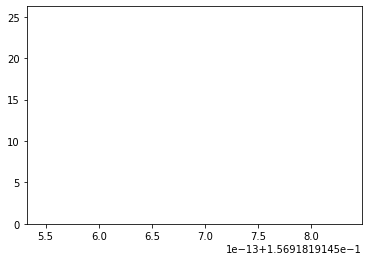

In [8]:
edgelengths= MakeBondHist(InputMesh.points,edgebonds)
np.mean(edgelengths)

# Energy Minimization

In [9]:
def mycallback(xi):
    counter=len(history)
    history.append(xi)
    tempP = xi.reshape((-1, 2))
    
    # stuff to screen
    print("iteration:"+"{0:0.1f}".format(counter)+"Total Area:" + "{0:0.2f}".format(vTotalArea(tempP,triangles)))
   
    #output for visualisation
    OutputMesh.points[:,0:2] = tempP           
    OutputMesh.write(DataFolder+RunFolder+RunName+"TempOutput"+"Output"+"{0:0.1f}".format(g0)+"_"+str(counter)+".vtk",binary=True)

In [10]:
# initial input points. Pout changes over time
Pout_ij =InputMesh.points[:,0:2] 
N = len(Pout_ij)

# the connectivity matrix --- this doesnt change over the run
A = np.zeros( (len(Pout_ij),len(Pout_ij)) )
for bond in edgebonds+interiorbonds:
    A[bond[0],bond[1]]=1
    A[bond[1],bond[0]]=1

# the triangles defining the connectivity data    
triangles=InputMesh.cells[0].data
# The initial area, which we want to penalise deviation from
TargetArea=TotalArea(Pout_ij,triangles)

for g0 in np.arange(g0start,g0end,g0step):
    
    print("Current g0"+"{0:0.1f}".format(g0))
    
    # Make the "prestress" matrix, referring to scale factors for the rest lengths
    g0_ij= np.ones((N,N),)
    for bond in edgebonds:
        g0_ij[bond[0],bond[1]]=g0
        g0_ij[bond[1],bond[0]]=g0   
    # the preferred rest lengths of all the springs
    r0_ij = g0_ij*dist(InputMesh.points[:,0:2] )

    # minimize
    history=[]
    Pout_ij = opt.minimize(energy, Pout_ij.ravel()
                           ,args=(A,r0_ij,angletriples,triangles,k,kd,theta0,B,TargetArea)
                           #,callback=mycallback
                           ,options={'disp': True}).x.reshape((-1, 2))
   

    # stuff to screen
    print("Total Area:" + "{0:0.2f}".format(vTotalArea(Pout_ij,triangles)))

    # write the output 
    OutputMesh.points[:,0:2] = Pout_ij  
    OutputMesh.point_data={"g0": np.repeat(g0,len(InputMesh.points))}   
    
    OutputMesh.write(DataFolder+RunFolder+RunName+"g0_"+"{0:0.1f}".format(g0)+".vtk",binary=True)  


Current g01.0
Optimization terminated successfully.
         Current function value: 8.667216
         Iterations: 0
         Function evaluations: 275
         Gradient evaluations: 1
Total Area:3.13
Current g01.1
         Current function value: 8.775879
         Iterations: 47
         Function evaluations: 27237
         Gradient evaluations: 99
Total Area:3.13
Current g01.2
         Current function value: 8.906190
         Iterations: 51
         Function evaluations: 28060
         Gradient evaluations: 102
Total Area:3.13
Current g01.3
         Current function value: 9.060107
         Iterations: 53
         Function evaluations: 32185
         Gradient evaluations: 117
Total Area:3.13
Current g01.4
         Current function value: 9.239584
         Iterations: 51
         Function evaluations: 32183
         Gradient evaluations: 117
Total Area:3.13
Current g01.5
         Current function value: 9.446573
         Iterations: 56
         Function evaluations: 32461
         Gr